In [1]:
import pandas as pd
import numpy as np
from matplotlib import rcParams
from datetime import date, datetime
import scipy.stats as stats
import sklearn as sk
from sklearn import metrics
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedKFold
import warnings
from sklearn.preprocessing import RobustScaler, MinMaxScaler, StandardScaler
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, BaggingClassifier, AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.feature_selection import RFE # wrapper method
from sklearn.linear_model import LogisticRegression #(This is one possible model to apply inside RFE)
from sklearn.linear_model import LassoCV # embedded method
warnings.filterwarnings("ignore")

In [2]:
hist= pd.DataFrame(pd.read_excel('historical.xlsx'))
predict= pd.DataFrame(pd.read_excel('predict.xlsx'))

Cleaning function for the dataset. Creates new variables and standartizes others

In [3]:
def data_cleaning(df):

    '''

    :param df: dataframe inicial
    :return: dataframe com o mesmo tratamento que o projeto 1
    '''
    final_df = df[~df.duplicated()] # drop duplicate rows
    final_df = final_df.set_index('CustomerID')

    final_df["Gender"] = final_df['Name'].str.partition(" ")[0]
    final_df = final_df.replace({"Gender":{"Mr.": 1,"Miss": 0,"Mrs.": 0}}) #Name Var Processing
    final_df.drop('Name', axis= 1, inplace= True)

    final_df['Education'] = final_df['Education'].str.title()
    # edu_encode = pd.get_dummies(final_df.Education, drop_first= True)
    # final_df = pd.concat([final_df, edu_encode], axis = 1) #Marital Status Var Processing
    # final_df.drop('Education', axis= 1, inplace = True)

    final_df['Marital_Status'] = final_df['Marital_Status'].str.title()
    # marital_encode = pd.get_dummies(final_df.Marital_Status, drop_first= True)
    # final_df = pd.concat([final_df, marital_encode], axis = 1) #Marital Status Var Processing
    # final_df.drop('Marital_Status', axis= 1, inplace = True)

    final_df['Age'] = final_df.Birthyear.apply(lambda x: date.today().year-x)
    final_df.drop('Birthyear', axis=1, inplace=True) #Age Var Processing

    final_df = final_df.replace({"Date_Adherence":{"2/29/2022": datetime.strptime("2022-03-01", '%Y-%m-%d')}})

    final_df["MntTotal"] = final_df['MntMeat&Fish'] + final_df['MntEntries'] + final_df['MntVegan&Vegetarian'] + final_df['MntDrinks'] + final_df['MntDesserts'] + final_df['MntAdditionalRequests']

    final_df.drop(['MntMeat&Fish', 'MntEntries', 'MntVegan&Vegetarian', 'MntDrinks', 'MntDesserts', 'MntAdditionalRequests'], axis=1, inplace=True)

    final_df['Days_As_Client'] = final_df['Date_Adherence'].apply(lambda x: (date.today() - x.date()).days) #Date Adherence Var Processing
    final_df['Days_As_Client'] = final_df['Days_As_Client'].apply(lambda x: 1 if x < 1 else x)
    final_df.drop('Date_Adherence', axis= 1, inplace = True)

    final_df['Response_Campaigns'] = final_df['Response_Cmp1'] + final_df['Response_Cmp2'] + final_df['Response_Cmp3'] + final_df['Response_Cmp4'] + final_df[
       'Response_Cmp5']
    final_df.drop(['Response_Cmp1', 'Response_Cmp2', 'Response_Cmp3', 'Response_Cmp4', 'Response_Cmp5'], axis=1, inplace=True)

    # final_df.drop(['CostContact', 'Revenue'], axis=1, inplace=True)
    return final_df

In [4]:
def fill_missing_values(dataframe, strategy='mode'):
    # Fill missing string values based on the selected strategy
    if strategy == 'mode':
        filled_dataframe = dataframe.fillna(dataframe.mode().iloc[0])
    elif strategy == 'median':
        filled_dataframe = dataframe.fillna(dataframe.median().iloc[0])
    elif strategy == 'mean':
        filled_dataframe = dataframe.fillna(dataframe.mean().iloc[0])

    return filled_dataframe

In [5]:
def model_statistics_classification(true_values, predictions, prints= True, matrix_print= True):
    cnf_matrix = metrics.confusion_matrix(true_values, predictions)
    if matrix_print:
        rcParams['figure.figsize']=(6,3)
        class_names=[1, 2, 3, 4] # name  of classes
        fig, ax = plt.subplots()
        tick_marks = np.arange(len(class_names))
        plt.xticks(tick_marks, class_names)
        plt.yticks(tick_marks, class_names)   # create heatmap
        sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="RdPu" ,fmt='g')
        ax.xaxis.set_label_position("top")
        plt.tight_layout()
        plt.title('Confusion matrix', y=1.1)
        plt.ylabel('Actual label')
        plt.xlabel('Predicted label')
        plt.show()
    else:
        print(cnf_matrix)
    if prints:
        print("Accuracy:",metrics.accuracy_score(true_values, predictions))
        print("Precision:",metrics.precision_score(true_values, predictions))
        print("Recall:",metrics.recall_score(true_values, predictions))
        print("F1 Score:",metrics.f1_score(true_values, predictions))
        print("Mathews Correlation Coefficient:",metrics.matthews_corrcoef(true_values, predictions))
    return metrics.accuracy_score(true_values, predictions) , metrics.precision_score(true_values, predictions), metrics.recall_score(true_values, predictions), metrics.f1_score(true_values, predictions, average='weighted'), metrics.matthews_corrcoef(true_values, predictions)
    #returns a list of statistics

In [6]:
hist = data_cleaning(hist)

In [7]:
skf = StratifiedKFold(n_splits = 5, random_state = 99, shuffle = True)

Feature Selection

In [8]:
y = hist['DepVar']
x = hist.drop('DepVar', axis=1)
# Split the data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [9]:
features_to_be_removed = []

Selecting Cat variables

In [10]:
def apply_chisquare(X,y,var,alpha=0.05):
    dfObserved = pd.crosstab(y,X)
    chi2, p, dof, expected = stats.chi2_contingency(dfObserved.values)
    dfExpected = pd.DataFrame(expected, columns=dfObserved.columns, index = dfObserved.index)
    if p<alpha:
        result="{0} is IMPORTANT for Prediction".format(var)
    else:
        result="{0} is NOT an important predictor. (Discard {0} from model)".format(var)
    print(result)

In [11]:
def select_best_cat_features(x,y):
    count = 1

    ############################################## APPLY SKF ######################################################
    for train_index, val_index in skf.split(x,y):
        x_train, x_val = x.iloc[train_index], x.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]

        ####################################### FILL MISSING DATA #################################################
        # Fill missing values (mode in categorical data)
        x_train = fill_missing_values(x_train, 'mode')
        x_val = fill_missing_values(x_val, 'mode')

        #################################### CORRECT MISCLASSIFICAIONS ############################################
        # Correct misclassifications in the Marital Status in training data
        x_train['Marital_Status'] = x_train['Marital_Status'].replace('BigConfusion',x_train['Marital_Status'].mode()[0])
        x_train['Marital_Status'] = x_train['Marital_Status'].replace('Together','Married')
        # Correct misclassifications in the Gender in training data
        x_train['Gender'] = x_train['Gender'].replace('?',x_train['Gender'].mode()[0])
        # Correct misclassifications in the Education in training data
        x_train['Education'] = x_train['Education'].replace('OldSchool',x_train['Education'].mode()[0])

        #################################### SELECT FEATURES WITH CHI-SQUARE #######################################
        print('_________________________________________________________________________________________________\n')
        print('                                     SPLIT ' + str(count) + '                                    ')
        print('_________________________________________________________________________________________________')

        # check which features to use using chi-square
        x_train_cat = x_train[['Gender','Education','Marital_Status']].copy()
        for var in x_train_cat:
            apply_chisquare(x_train_cat[var],y_train, var)

        count+=1

In [12]:
select_best_cat_features(x,y)

_________________________________________________________________________________________________

                                     SPLIT 1                                    
_________________________________________________________________________________________________
Gender is NOT an important predictor. (Discard Gender from model)
Education is NOT an important predictor. (Discard Education from model)
Marital_Status is IMPORTANT for Prediction
_________________________________________________________________________________________________

                                     SPLIT 2                                    
_________________________________________________________________________________________________
Gender is NOT an important predictor. (Discard Gender from model)
Education is NOT an important predictor. (Discard Education from model)
Marital_Status is IMPORTANT for Prediction
__________________________________________________________________________________

Gender- 5 NO -> Remove
Education- 4 NO 1 YES -> Remove
Marital Status- 1 NO 4 YES -> Keep

In [13]:
features_to_be_removed= features_to_be_removed + ['Gender', 'Education']

In [14]:
x= x.drop(['Gender', 'Education'], axis=1)

Selection using var

In [15]:
def apply_variance(x_train):
    print(x_train.var())

In [16]:
def select_features_variance(x,y):
    count = 1
    for train_index, val_index in skf.split(x,y):
        x_train, x_val = x.iloc[train_index], x.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]

        ####################################### FILL MISSING DATA #################################################
        # Fill missing values (median in numerical data)
        x_train = fill_missing_values(x_train, 'median')
        x_val = fill_missing_values(x_val, 'median')

        ######################################### SELECT FEATURES #################################################
        print('_________________________________________________________________________________________________\n')
        print('                                     SPLIT ' + str(count) + '                                    ')
        print('_________________________________________________________________________________________________')

        # check which features to use using variance
        apply_variance(x_train)

        count+=1

In [17]:
select_features_variance(x,y)

_________________________________________________________________________________________________

                                     SPLIT 1                                    
_________________________________________________________________________________________________
Income                  1.280089e+09
Kid_Younger6            2.953654e-01
Children_6to18          2.931343e-01
Recency                 1.016232e+08
NumOfferPurchases       5.439750e+00
NumAppPurchases         7.553717e+00
NumTakeAwayPurchases    1.179090e+01
NumStorePurchases       1.099567e+01
NumAppVisitsMonth       7.420221e+00
Complain                1.186193e-02
CostContact             0.000000e+00
Revenue                 0.000000e+00
Age                     1.429341e+02
MntTotal                9.902834e+07
Days_As_Client          4.180478e+04
Response_Campaigns      4.491996e-01
dtype: float64
_________________________________________________________________________________________________

                

Revenue e cost contact tem var de 0 por isso serao removidas

In [18]:
features_to_be_removed= features_to_be_removed + ['Revenue', 'CostContact']

In [19]:
x= x.drop(['Revenue', 'CostContact'], axis=1)

selection using dt

Correlations

In [20]:
def cor_heatmap(cor):
    plt.figure(figsize=(20,10))
    sns.heatmap(data = cor, annot = True, cmap = plt.cm.Reds, fmt='.1')
    plt.show()

In [21]:
def apply_correlation(X_train):
    correlation_matrix = X_train.corr(method = 'spearman')
    cor_heatmap(correlation_matrix)
    # Find the pairs of variables with correlation above the threshold
    pairs_above_threshold = (correlation_matrix.abs() > 0.8) & (correlation_matrix != 1.0)

    # Get the indices of the variables that have a correlation above the threshold
    indices = [(correlation_matrix.index[i], correlation_matrix.columns[j])
               for i, j in zip(*pairs_above_threshold.values.nonzero())]

    # Create a DataFrame to store the pairs and correlation coefficients
    results_df = pd.DataFrame(columns=['Variable 1', 'Variable 2', 'Correlation'])

    # Populate the DataFrame with the pairs and correlation coefficients
    for var1, var2 in indices:
        correlation = correlation_matrix.loc[var1, var2]
        results_df = results_df.append({'Variable 1': var1, 'Variable 2': var2, 'Correlation': correlation},
                                       ignore_index=True)

    # Display the results in tabular format
    print(results_df)

In [22]:
def redundant_features(x,y):
    count = 1
    for train_index, val_index in skf.split(x,y):
        x_train, x_val = x.iloc[train_index], x.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]

        ####################################### FILL MISSING DATA #################################################
        x_train = fill_missing_values(x_train, 'median')
        x_val = fill_missing_values(x_val, 'median')

        ######################################### SELECT FEATURES #################################################
        print('_________________________________________________________________________________________________\n')
        print('                                     SPLIT ' + str(count) + '                                    ')
        print('_________________________________________________________________________________________________')

        # check which features to use using spearman correlation
        apply_correlation(x_train)

        count+=1

_________________________________________________________________________________________________

                                     SPLIT 1                                    
_________________________________________________________________________________________________


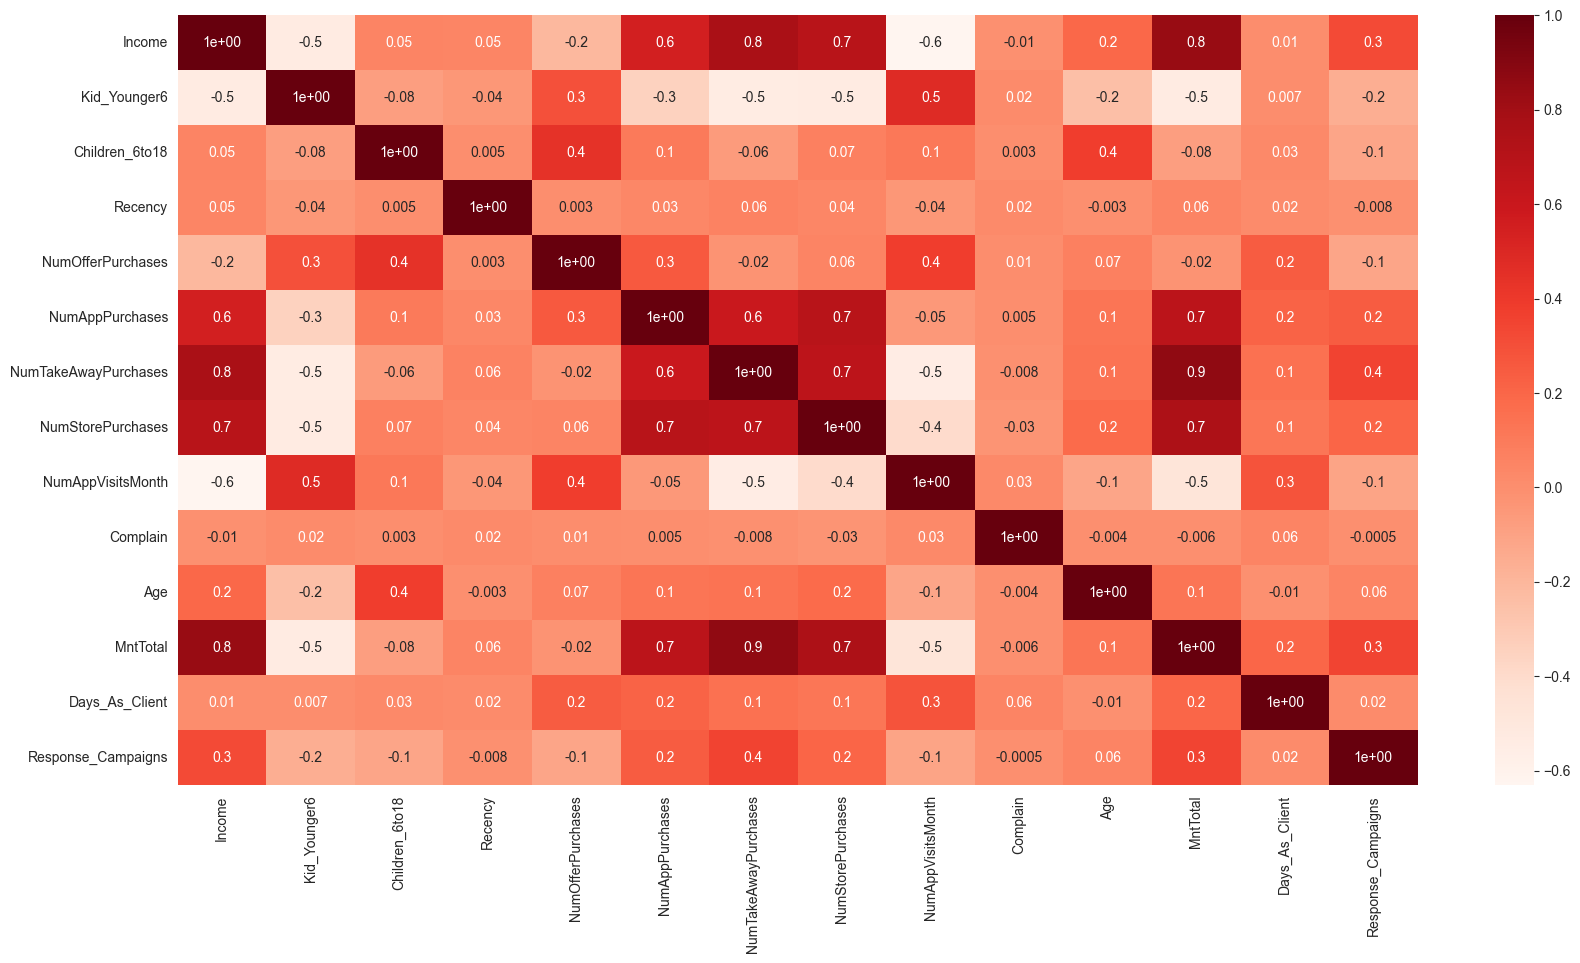

             Variable 1            Variable 2  Correlation
0                Income              MntTotal     0.834544
1  NumTakeAwayPurchases              MntTotal     0.861123
2              MntTotal                Income     0.834544
3              MntTotal  NumTakeAwayPurchases     0.861123
_________________________________________________________________________________________________

                                     SPLIT 2                                    
_________________________________________________________________________________________________


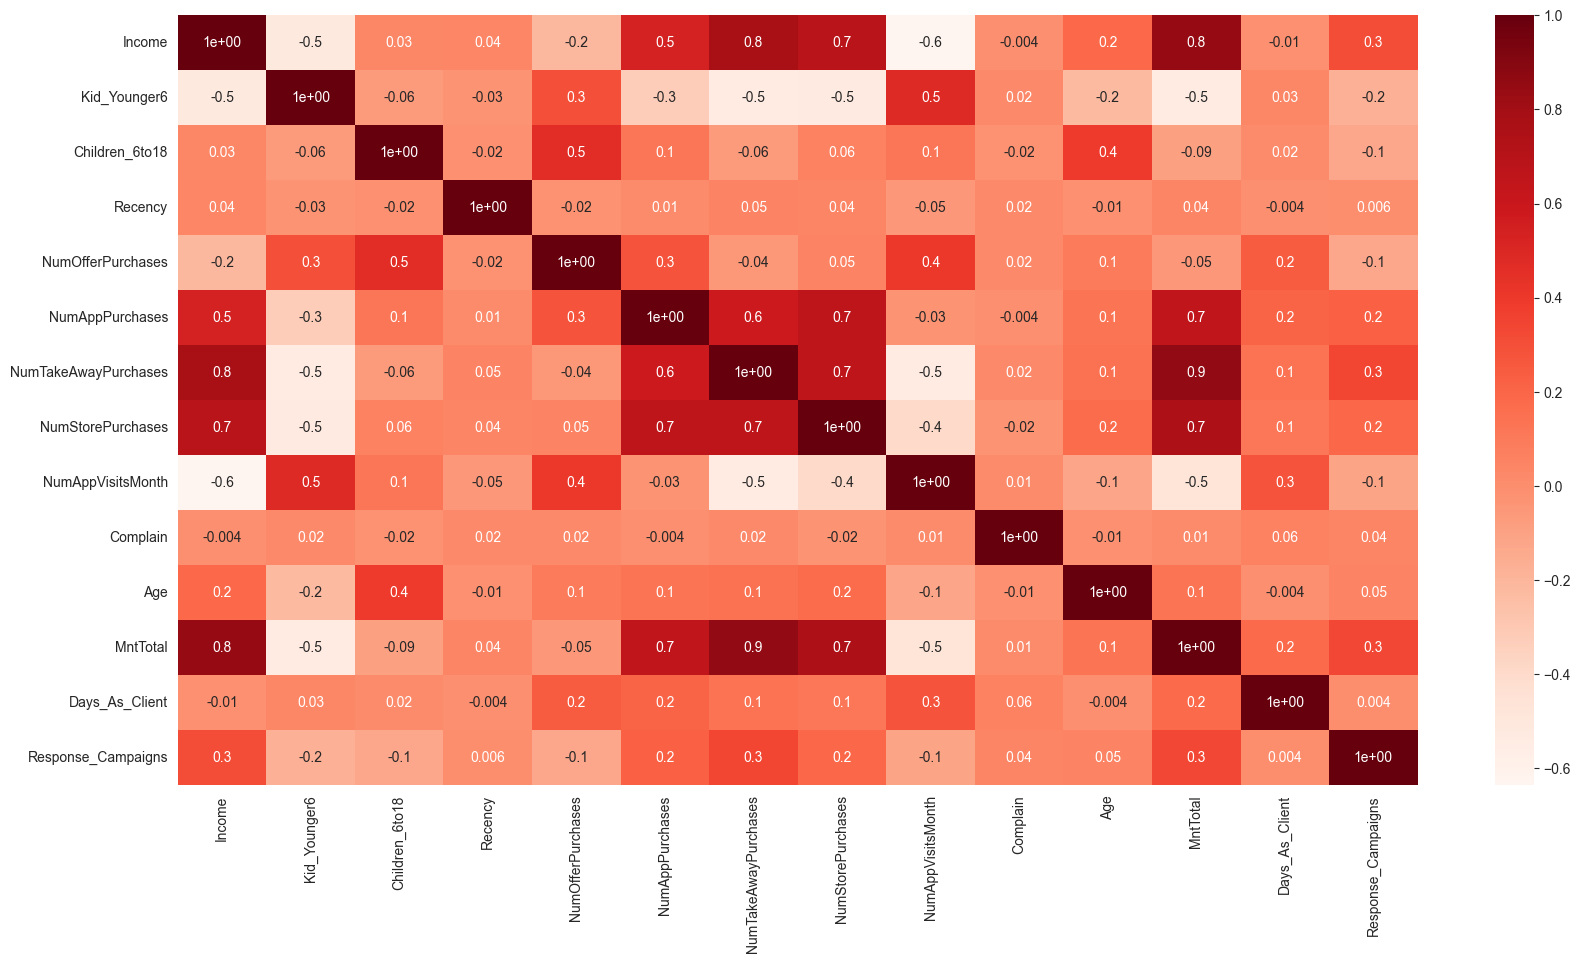

             Variable 1            Variable 2  Correlation
0                Income              MntTotal     0.842142
1  NumTakeAwayPurchases              MntTotal     0.856804
2              MntTotal                Income     0.842142
3              MntTotal  NumTakeAwayPurchases     0.856804
_________________________________________________________________________________________________

                                     SPLIT 3                                    
_________________________________________________________________________________________________


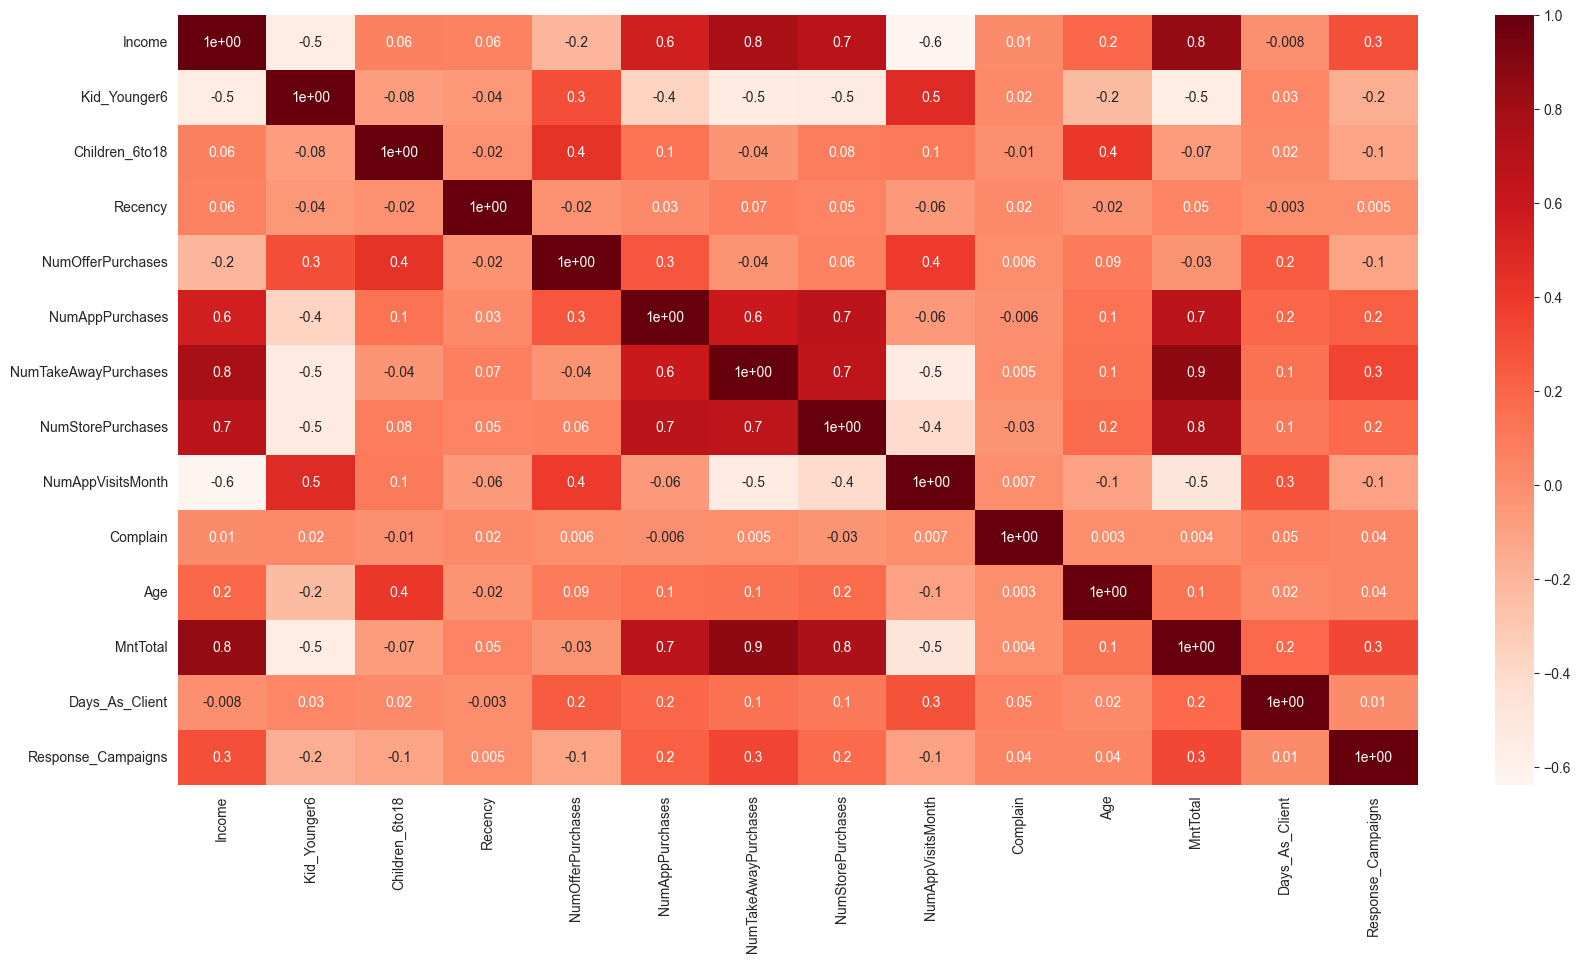

             Variable 1            Variable 2  Correlation
0                Income              MntTotal     0.849993
1  NumTakeAwayPurchases              MntTotal     0.871740
2              MntTotal                Income     0.849993
3              MntTotal  NumTakeAwayPurchases     0.871740
_________________________________________________________________________________________________

                                     SPLIT 4                                    
_________________________________________________________________________________________________


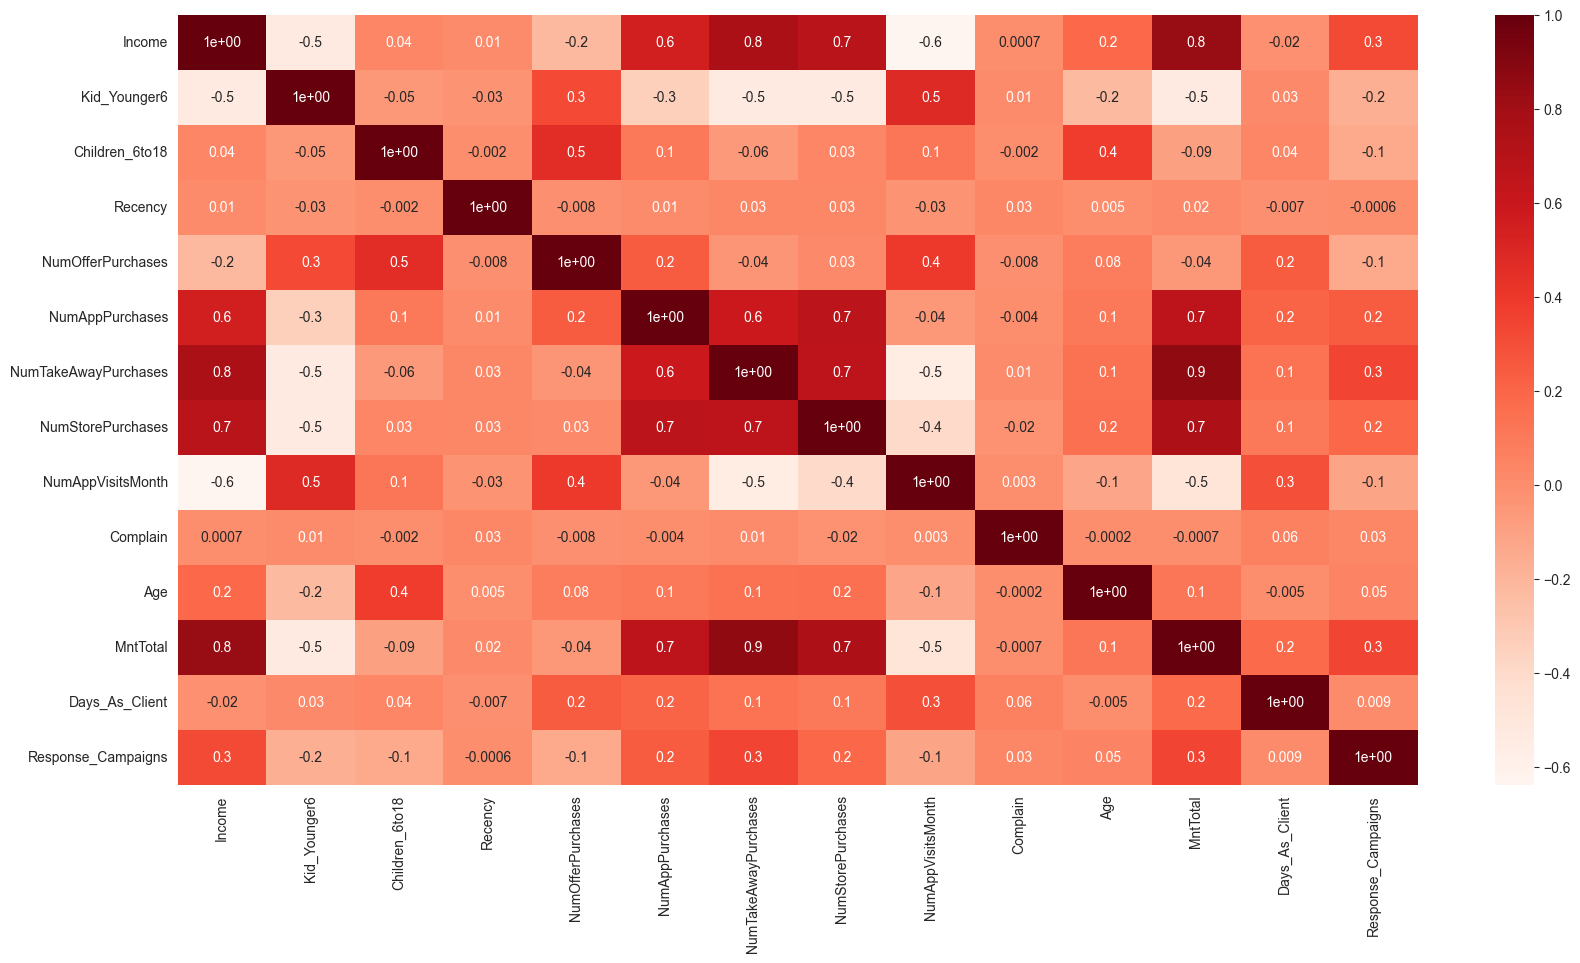

             Variable 1            Variable 2  Correlation
0                Income              MntTotal     0.836502
1  NumTakeAwayPurchases              MntTotal     0.860847
2              MntTotal                Income     0.836502
3              MntTotal  NumTakeAwayPurchases     0.860847
_________________________________________________________________________________________________

                                     SPLIT 5                                    
_________________________________________________________________________________________________


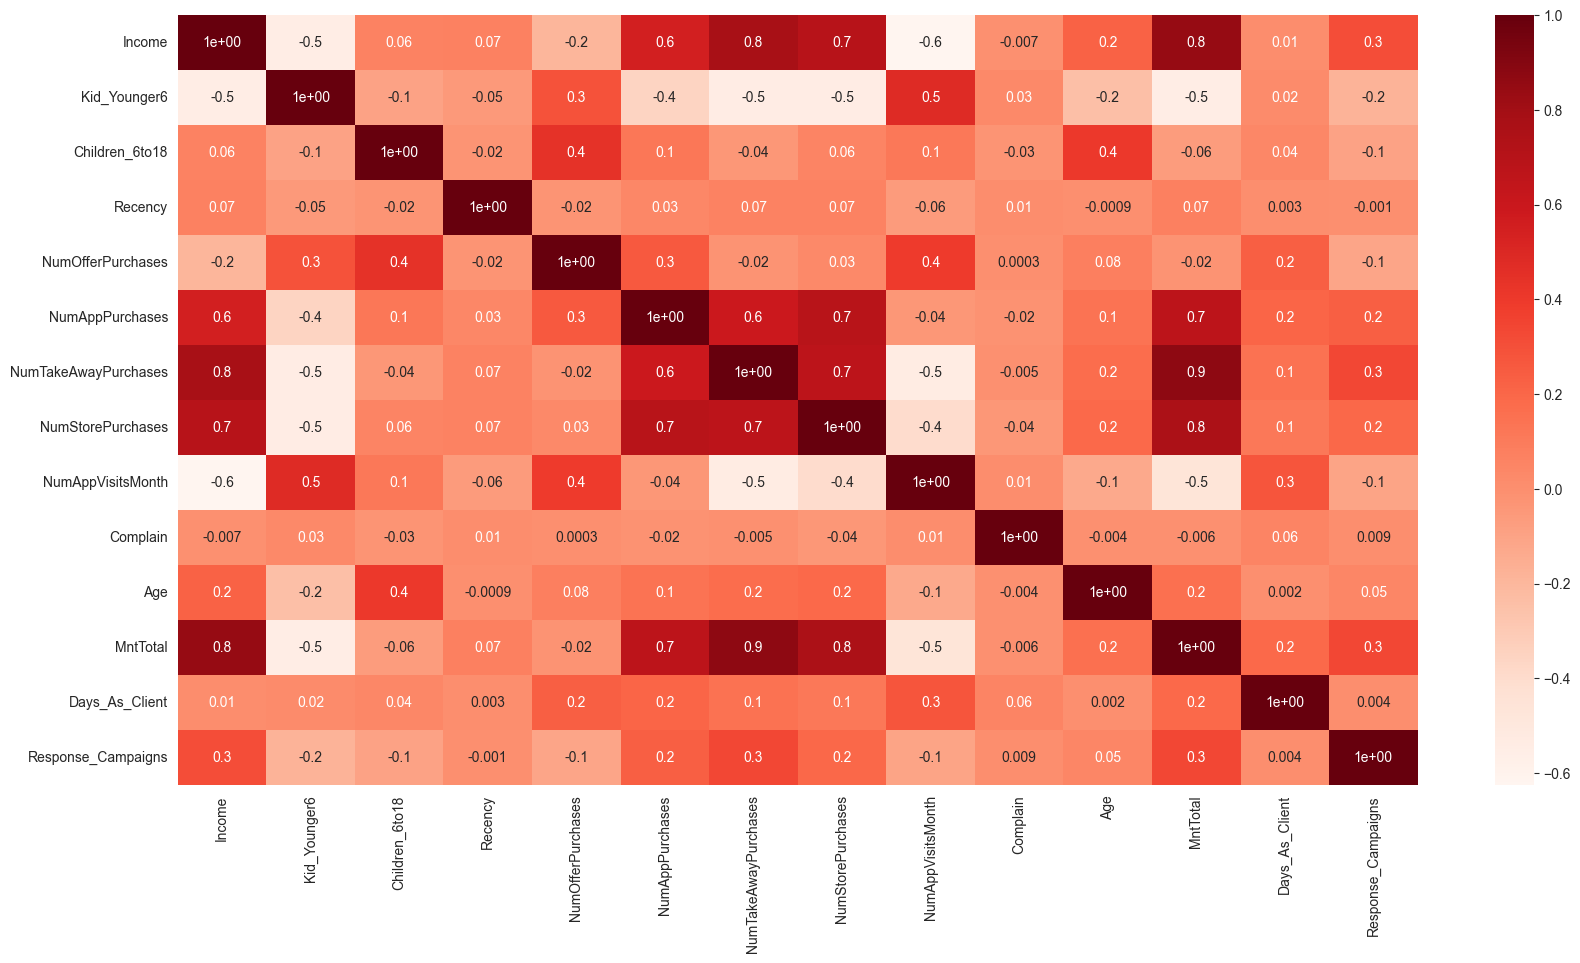

             Variable 1            Variable 2  Correlation
0                Income              MntTotal     0.847547
1  NumTakeAwayPurchases              MntTotal     0.870719
2              MntTotal                Income     0.847547
3              MntTotal  NumTakeAwayPurchases     0.870719


In [23]:
redundant_features(x, y)

Baseado nestes resultados o grupo income, numtakeawaypurchases e mnttotal tera de ser estudado de modo a escolher qual (ou quais) se mantem e quais deixar

In [24]:
def plot_importance(variables,name):
    imp_features = variables.sort_values()
    plt.figure(figsize=(12,8))
    imp_features.plot(kind = "barh")
    plt.title("Feature importance using " + name + " Model")
    plt.show()

In [25]:
def apply_dt(x_train, y_train):
    dt = DecisionTreeClassifier(random_state = 99).fit(x_train, y_train)
    feature_importances = pd.Series(dt.feature_importances_, index = x_train.columns)
    plot_importance(feature_importances, 'DT')
    return  feature_importances

In [26]:
def select_best_features_dt(x, y):
    count = 1
    for train_index, val_index in skf.split(x,y):
        x_train, x_val = x.iloc[train_index], x.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]

        ####################################### FILL MISSING DATA #################################################
        # Fill missing values in training data
        x_train = fill_missing_values(x_train, 'median')
        x_val = fill_missing_values(x_val, 'median')

        ######################################### SELECT FEATURES #################################################
        print('_________________________________________________________________________________________________\n')
        print('                                     SPLIT ' + str(count) + '                                    ')
        print('_________________________________________________________________________________________________')

        # check which features to use using decision Tree
        x_train = x_train.drop(['Marital_Status'], axis = 1)
        apply_dt(x_train, y_train)

        count+=1

_________________________________________________________________________________________________

                                     SPLIT 1                                    
_________________________________________________________________________________________________


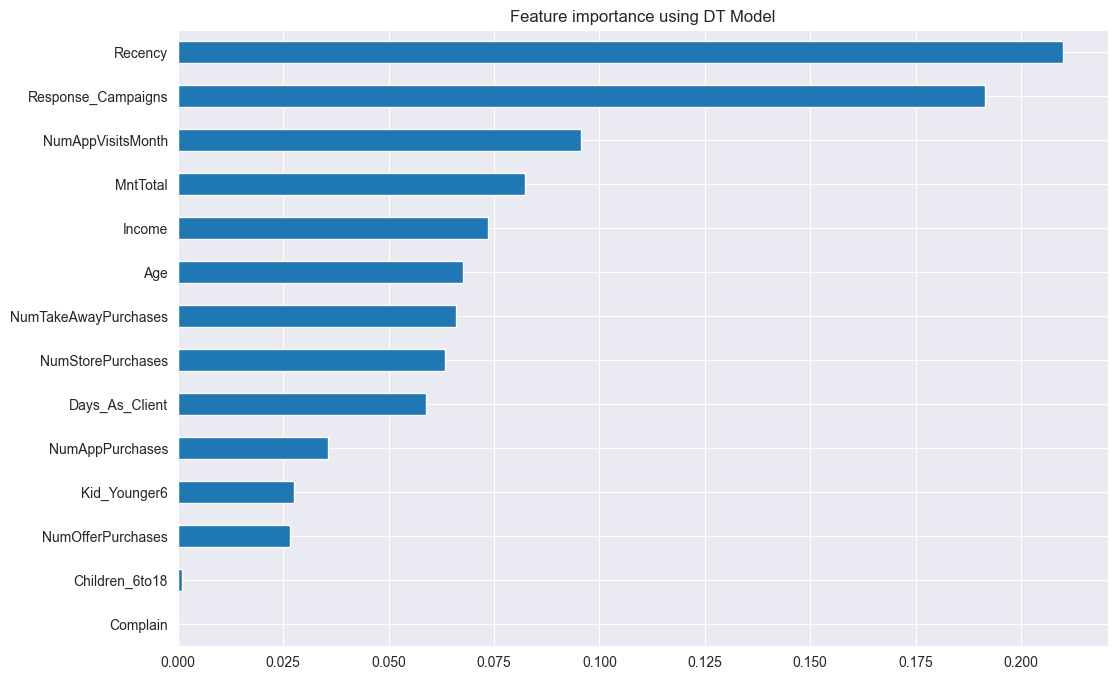

_________________________________________________________________________________________________

                                     SPLIT 2                                    
_________________________________________________________________________________________________


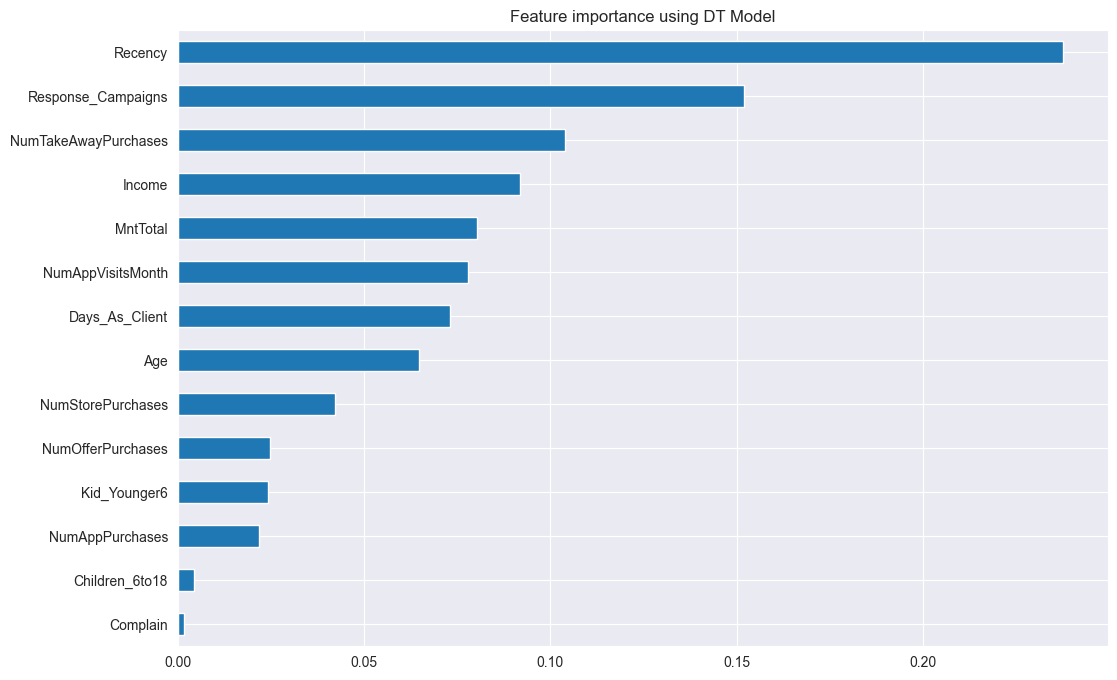

_________________________________________________________________________________________________

                                     SPLIT 3                                    
_________________________________________________________________________________________________


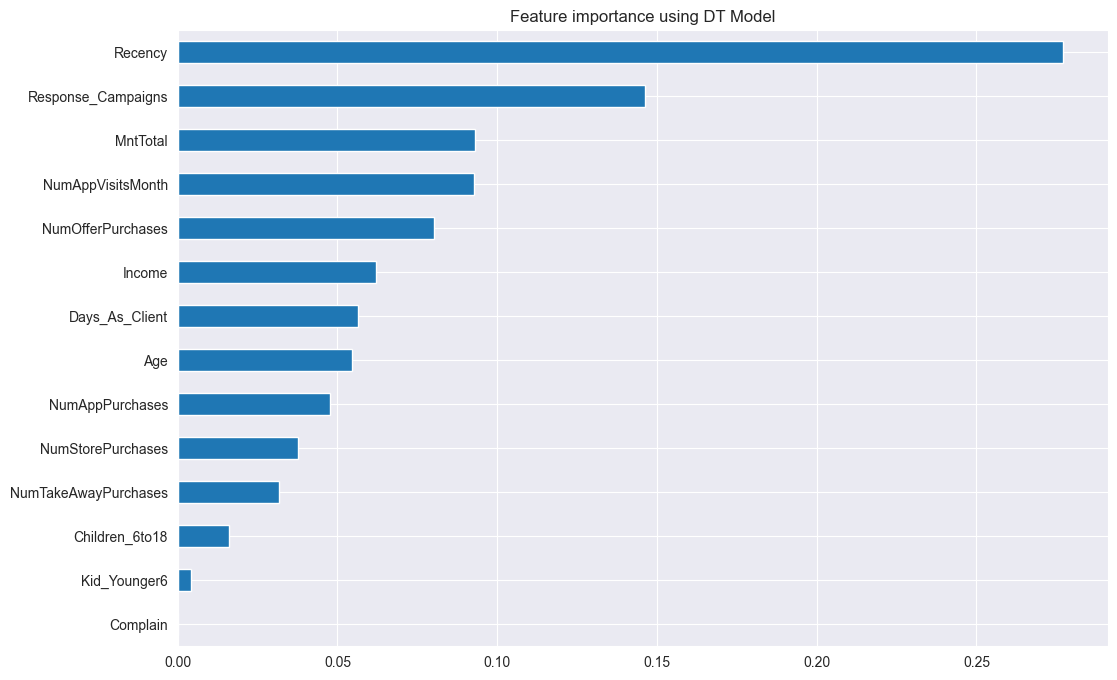

_________________________________________________________________________________________________

                                     SPLIT 4                                    
_________________________________________________________________________________________________


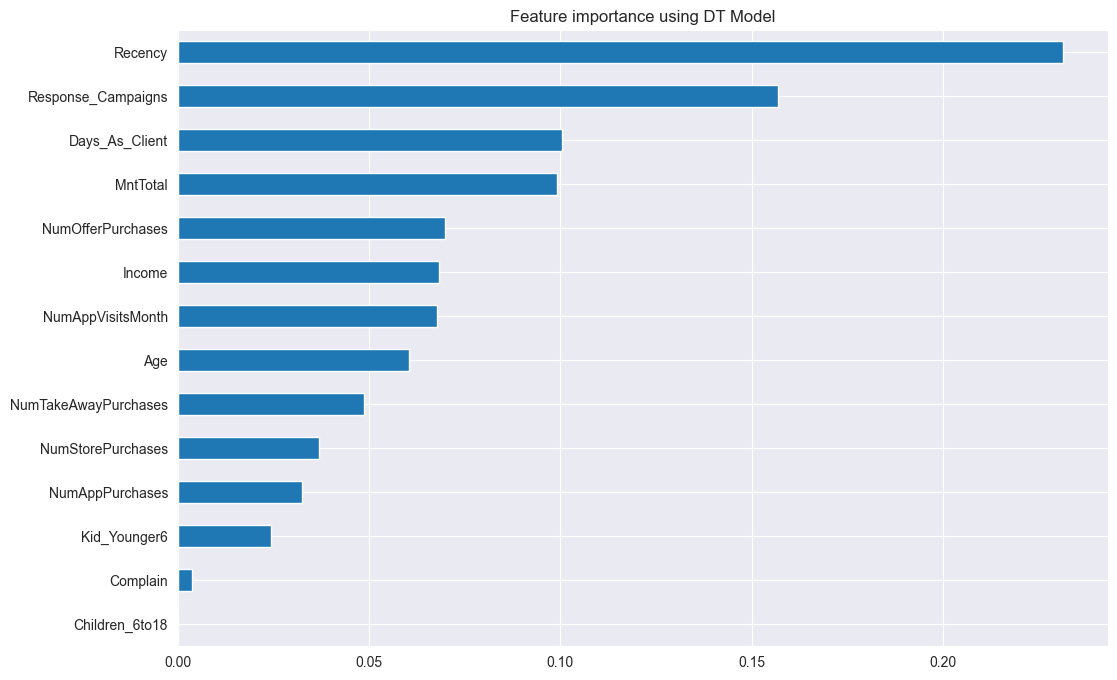

_________________________________________________________________________________________________

                                     SPLIT 5                                    
_________________________________________________________________________________________________


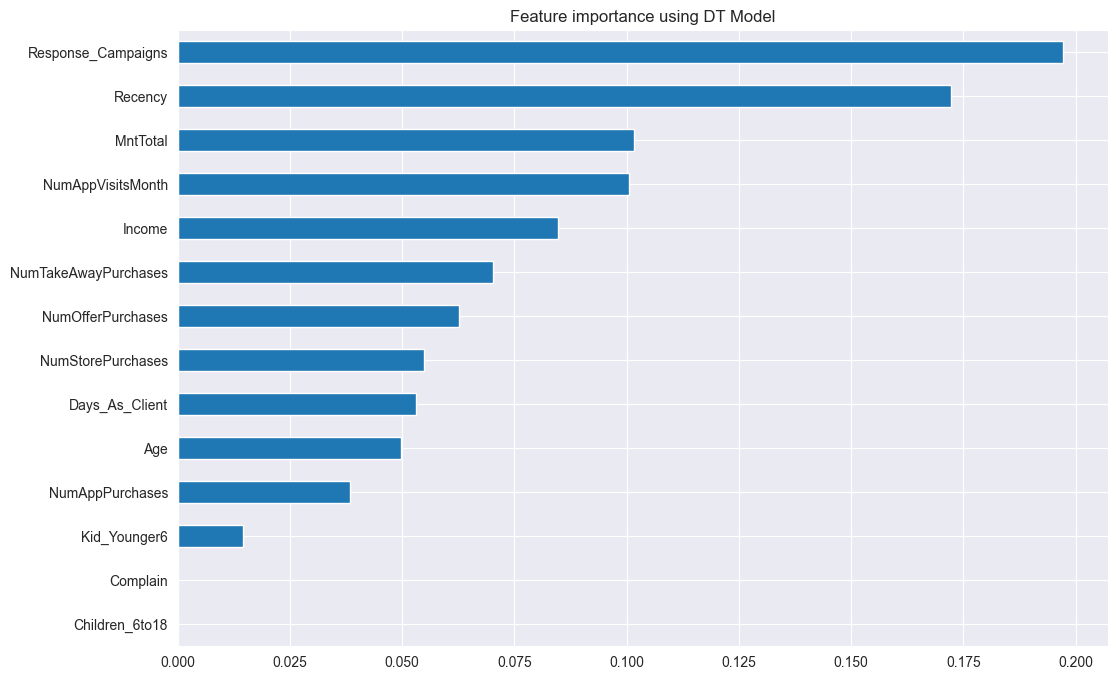

In [27]:
select_best_features_dt(x,y)

Como mnttotal é a variavel que aparece com maior importancia na maioria dos splits será essa a mantida

In [28]:
features_to_be_removed = features_to_be_removed + ['Income', 'NumTakeAwayPurchases']

In [29]:
x= x.drop(['Income', 'NumTakeAwayPurchases'], axis=1)

In [42]:
def apply_rfe(X_train, y_train):
    rfe = RFE(estimator = LogisticRegression(), n_features_to_select = 5)
    rfe.fit_transform(X = X_train, y = y_train)
    selected_features = pd.Series(rfe.support_, index = X_train.columns)
    print(selected_features)
    return selected_features

In [31]:
def apply_lasso(X_train, y_train):
    lasso = LassoCV().fit(X_train, y_train)
    coef = pd.Series(lasso.coef_, index = X_train.columns)
    plot_importance(coef,'Lasso')
    return  coef

In [43]:
def select_best_features(x,y):
    count = 1
    selected_features_table = pd.DataFrame(columns=['RFE', 'LASSO', 'DT'])
    for train_index, val_index in skf.split(x,y):
        x_train, x_val = x.iloc[train_index], x.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]

        ####################################### FILL MISSING DATA #################################################
        x_train = fill_missing_values(x_train, 'median')
        x_val = fill_missing_values(x_val, 'median')

        ########################################### SCALE DATA ####################################################
        numerical_data = x_train.drop(['Marital_Status'], axis = 1).copy()
        scaler = MinMaxScaler().fit(numerical_data)
        x_train_scaled = scaler.transform(numerical_data)
        x_train_scaled = pd.DataFrame(x_train_scaled, columns = numerical_data.columns)

        ######################################### SELECT FEATURES #################################################
        print('_________________________________________________________________________________________________\n')
        print('                                     SPLIT ' + str(count) + '                                    ')
        print('_________________________________________________________________________________________________')

        # Check which features to use using RFE
        rfe_features = apply_rfe(x_train_scaled, y_train)

        # Check which features to use using LASSO
        lasso_features = apply_lasso(x_train_scaled, y_train)

        # Check which features to use using DT
        dt_features = apply_dt(x_train_scaled, y_train)

        # Append the selected features to the DataFrame
        selected_features_table = selected_features_table.append({
            'RFE': rfe_features,
            'LASSO': lasso_features,
            'DT': dt_features
        }, ignore_index=True)

        count += 1
    return  selected_features_table

_________________________________________________________________________________________________

                                     SPLIT 1                                    
_________________________________________________________________________________________________
Kid_Younger6          False
Children_6to18        False
Recency                True
NumOfferPurchases     False
NumAppPurchases       False
NumStorePurchases      True
NumAppVisitsMonth      True
Complain              False
Age                   False
MntTotal               True
Days_As_Client        False
Response_Campaigns     True
dtype: bool


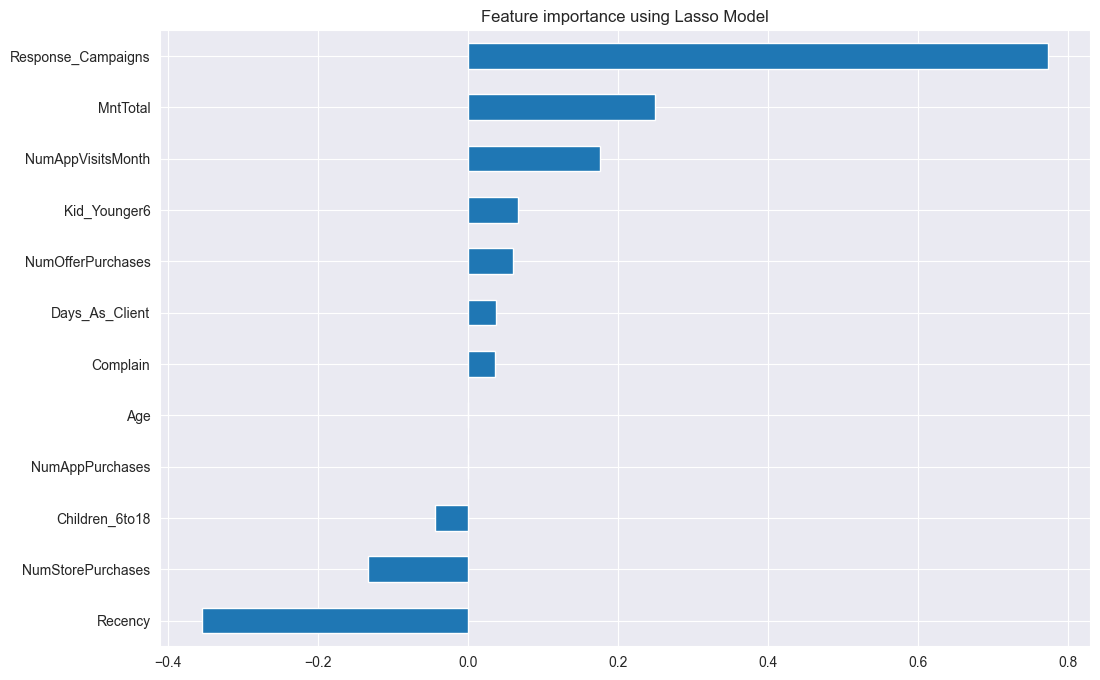

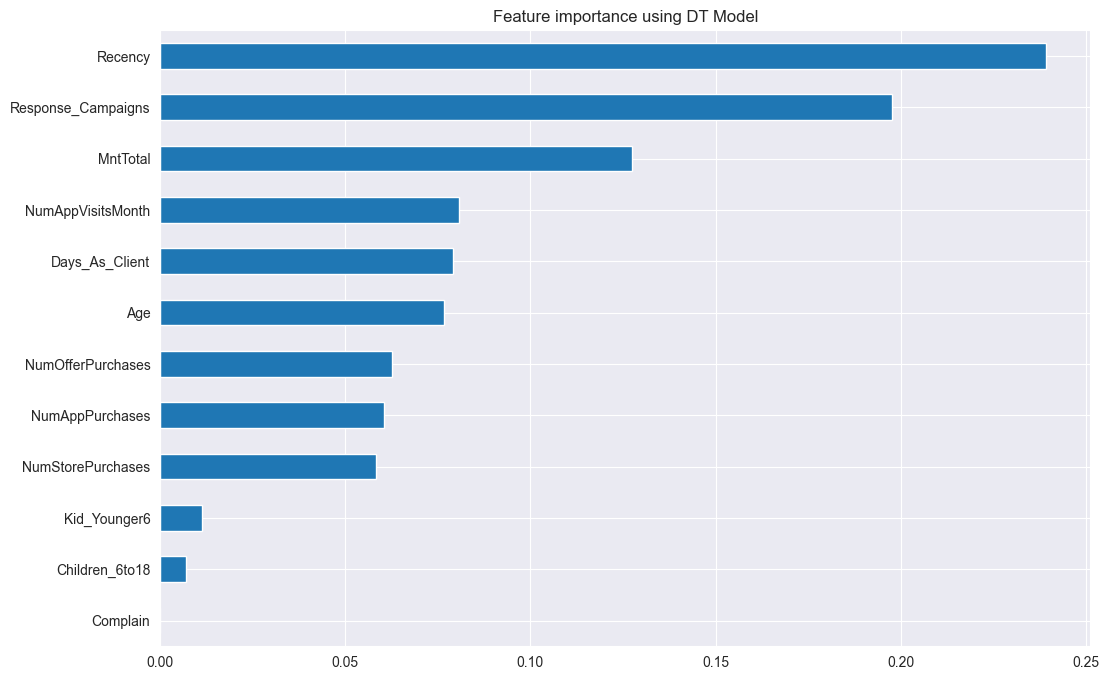

_________________________________________________________________________________________________

                                     SPLIT 2                                    
_________________________________________________________________________________________________
Kid_Younger6          False
Children_6to18        False
Recency                True
NumOfferPurchases     False
NumAppPurchases       False
NumStorePurchases      True
NumAppVisitsMonth      True
Complain              False
Age                   False
MntTotal               True
Days_As_Client        False
Response_Campaigns     True
dtype: bool


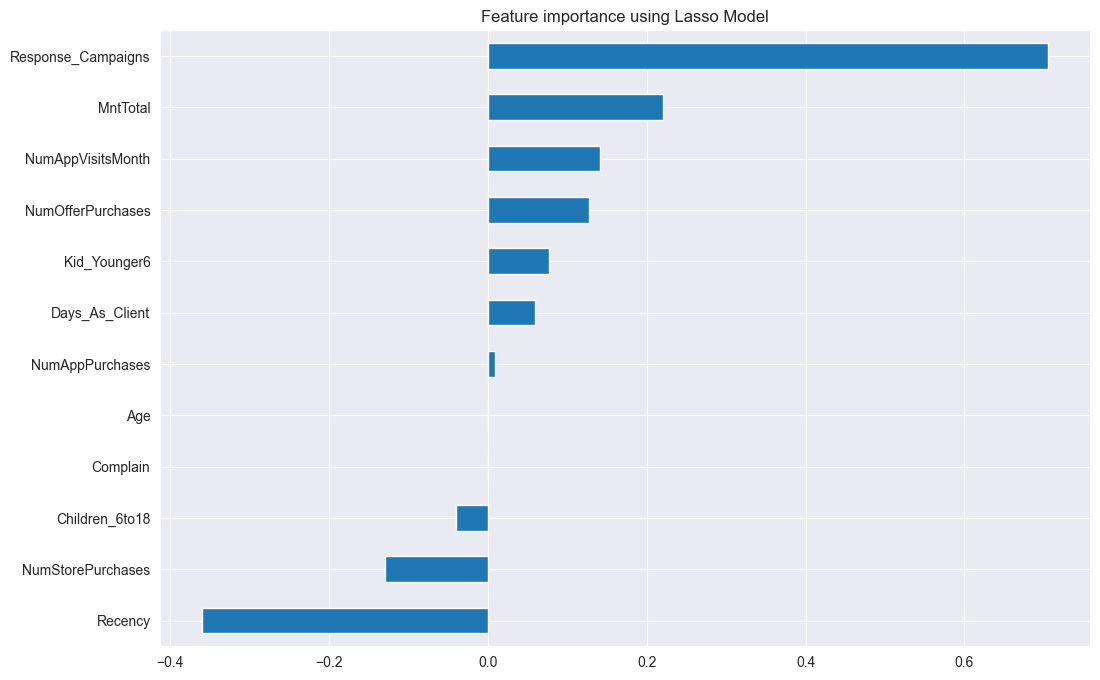

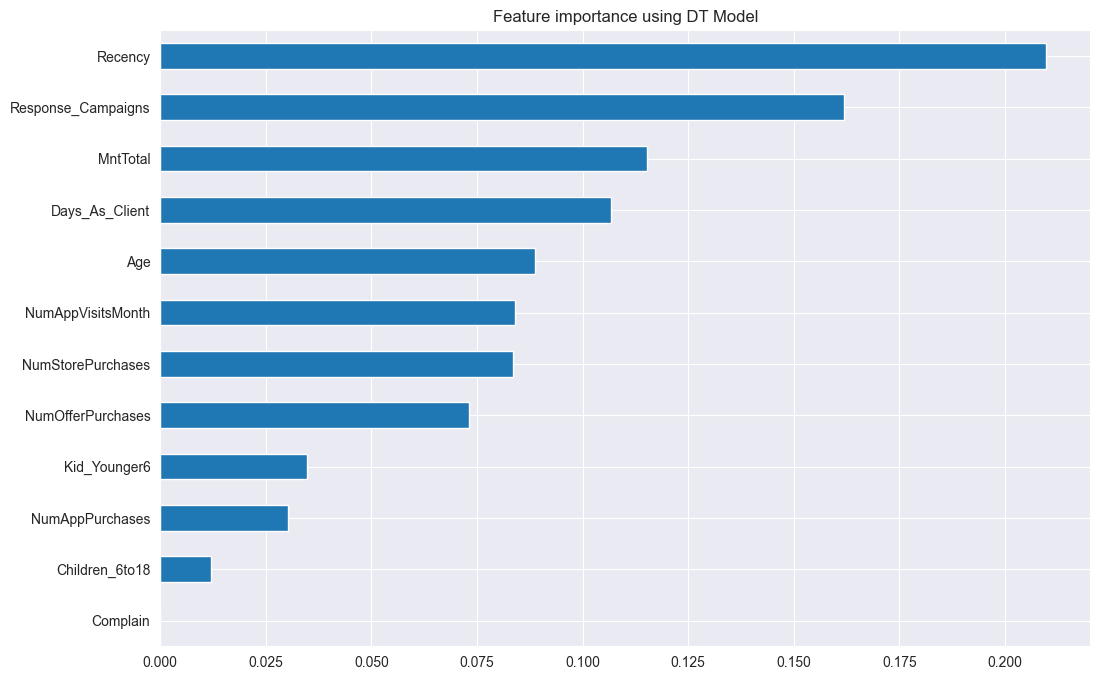

_________________________________________________________________________________________________

                                     SPLIT 3                                    
_________________________________________________________________________________________________
Kid_Younger6          False
Children_6to18        False
Recency                True
NumOfferPurchases     False
NumAppPurchases       False
NumStorePurchases      True
NumAppVisitsMonth      True
Complain              False
Age                   False
MntTotal               True
Days_As_Client        False
Response_Campaigns     True
dtype: bool


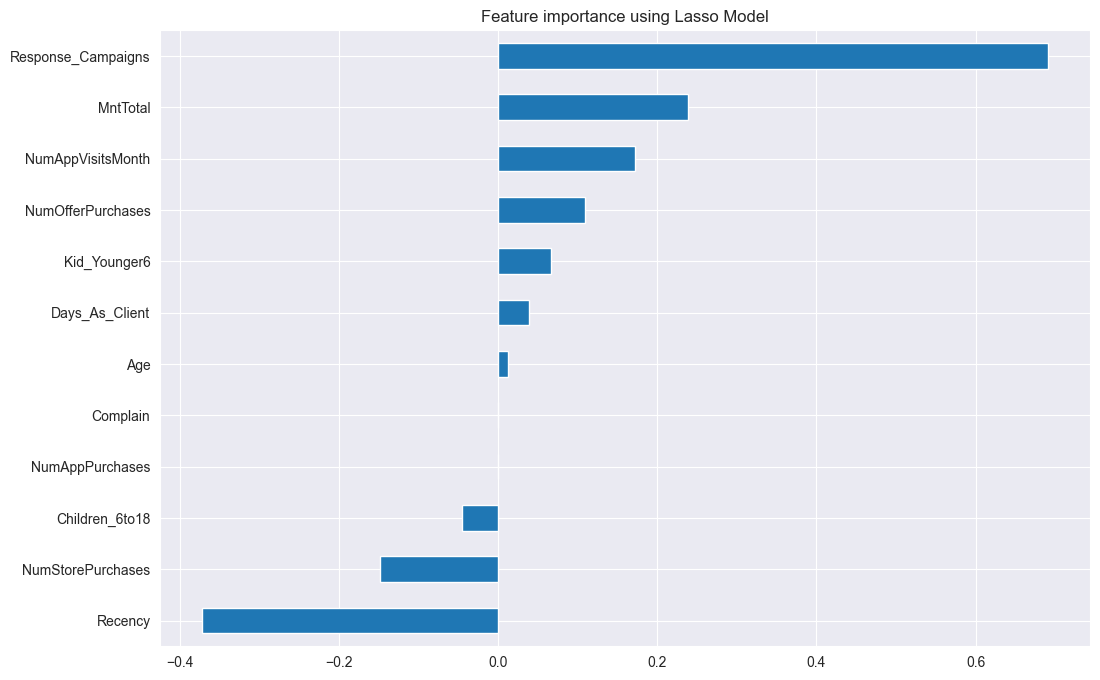

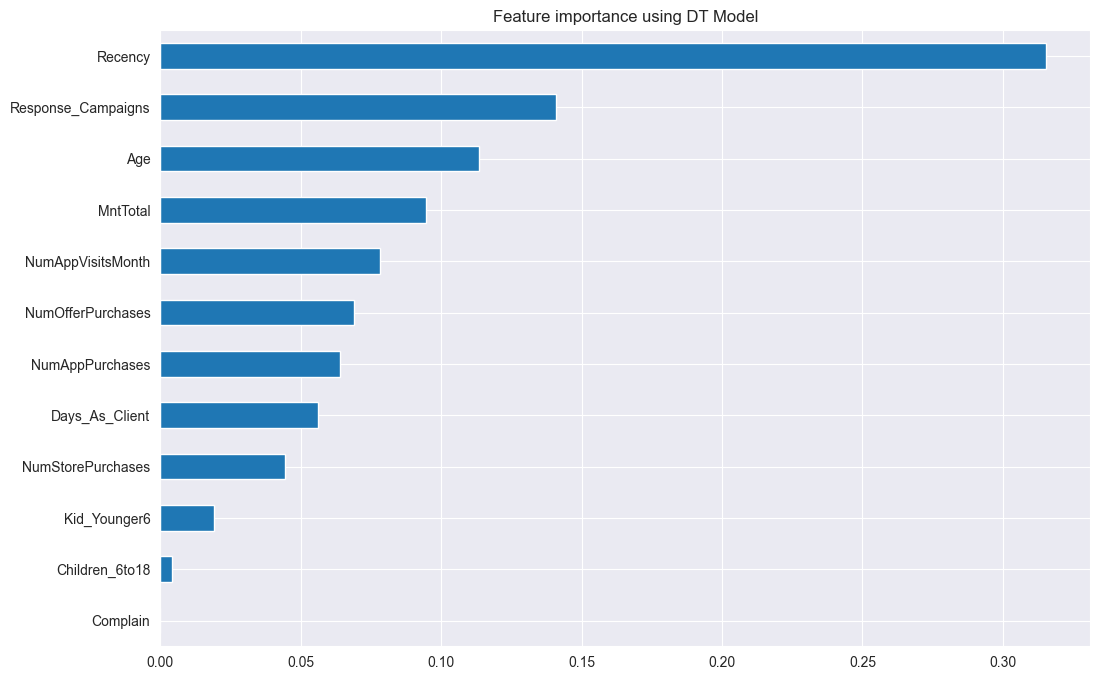

_________________________________________________________________________________________________

                                     SPLIT 4                                    
_________________________________________________________________________________________________
Kid_Younger6          False
Children_6to18        False
Recency                True
NumOfferPurchases     False
NumAppPurchases       False
NumStorePurchases      True
NumAppVisitsMonth      True
Complain              False
Age                   False
MntTotal               True
Days_As_Client        False
Response_Campaigns     True
dtype: bool


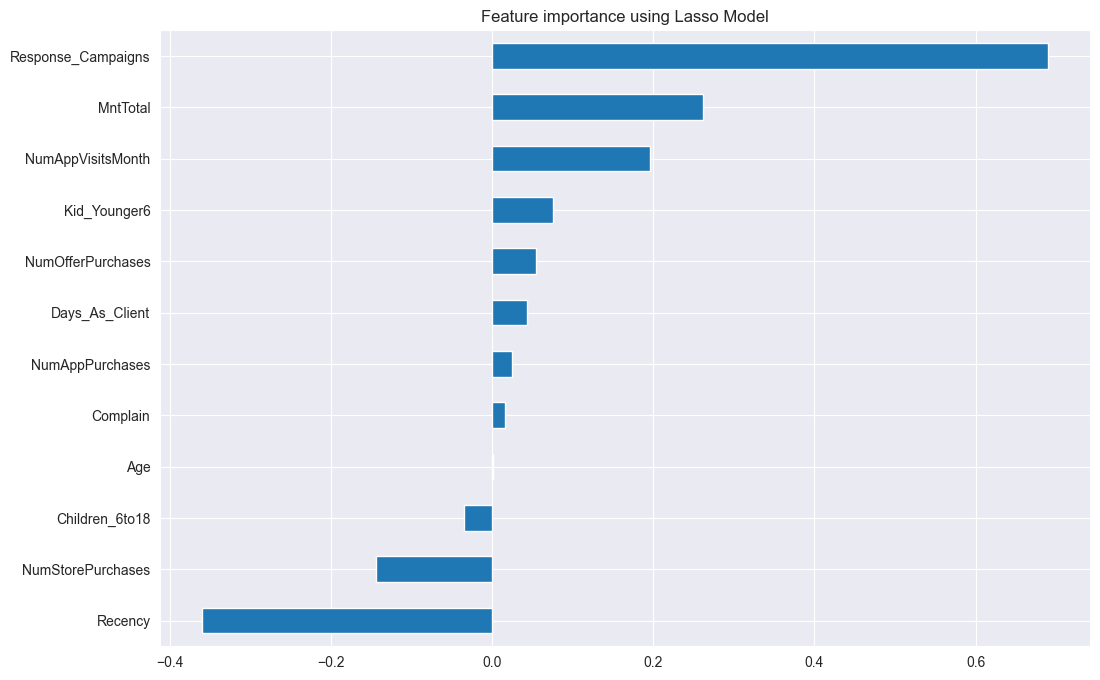

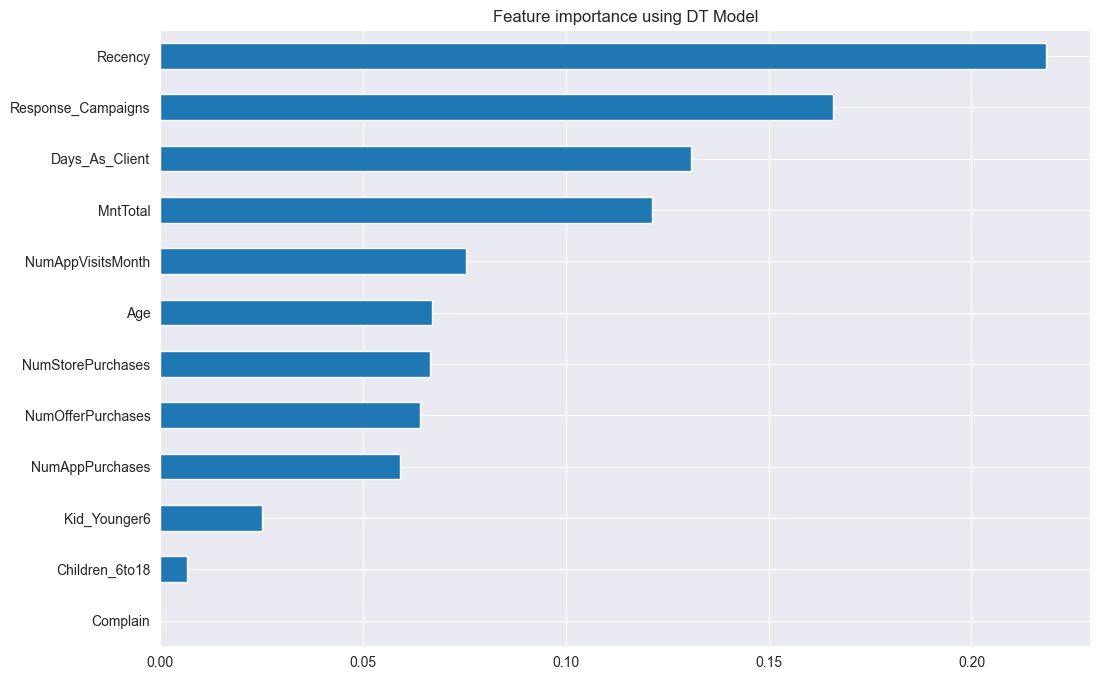

_________________________________________________________________________________________________

                                     SPLIT 5                                    
_________________________________________________________________________________________________
Kid_Younger6          False
Children_6to18        False
Recency                True
NumOfferPurchases     False
NumAppPurchases       False
NumStorePurchases      True
NumAppVisitsMonth      True
Complain              False
Age                   False
MntTotal               True
Days_As_Client        False
Response_Campaigns     True
dtype: bool


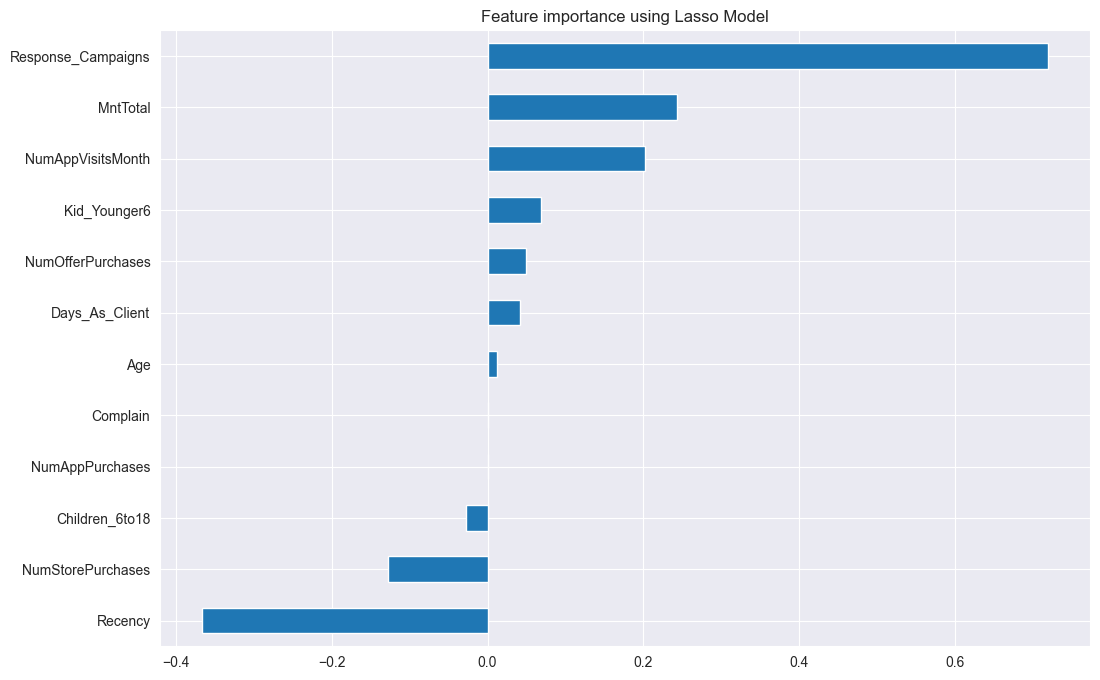

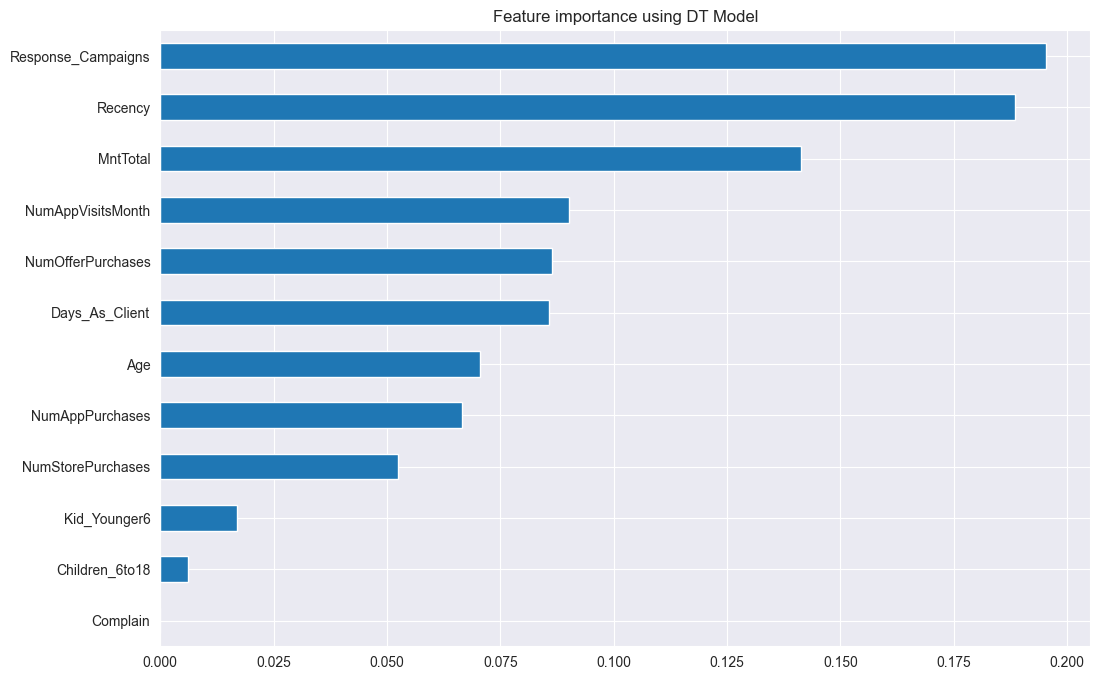

In [44]:
table = select_best_features(x, y)

| Predictor | RFE | Lasso | DT | What to do? (One possible way to "solve") |
| --- | --- | --- | --- | --- |
Response Campaigns | 2 YES | X | 0 YES |REMOVE |
Rcn | 0 YES | 5 YES | 5 YES | Try with and without |
Mnt | 5 YES | 5 YES | 5 YES | KEEP |
Clothes | 5 YES | 4 YES | 4 YES | KEEP |
Kitchen | 0 YES | 1 YES | 1 YES | REMOVE |
SmallAppliances | 0 YES | 2 YES | 4 YES | Try with and Without |
HouseKeeping | 0 YES | 0 YES | 2 YES | REMOVE |
Toys | 4 YES | 0 YES | 1 YES | Try with and without |
NetPurchase | 4 YES | 5 YES | 3 YES | KEEP |
Recomendation | 5 YES | 2 YES | 0 YES | Try with and Without |
CostPerContact | | | | REMOVE - Constant Feature|
RevenuePerPositiveAnswer | | | | REMOVE - Constant Feature|
Income | | | | REMOVE (Highly correlated with Mnt) |
Frq | |  | | REMOVE (Highly Correlated with Mnt) |
CatPurchase | |  | | REMOVE (Highly Correlated with NetPurchase) |

In [19]:
from scipy.stats import chi2_contingency

# Assuming 'x' is your feature DataFrame and 'y' is the target variable
p_values = []
for column in x_train.columns:
    contingency_table = pd.crosstab(x_train[column], y_train)
    _, p_value, _, _ = chi2_contingency(contingency_table)
    p_values.append(p_value)

# Set a significance level
significance_level = 0.1

# Select features based on p-values
selected_features = [column for column, p_value in zip(x_train.columns, p_values) if p_value < significance_level]


In [20]:
selected_features

['Children_6to18',
 'Recency',
 'NumAppVisitsMonth',
 'Married',
 'Single',
 'Together',
 'Widow',
 'Age',
 'Response_Campaigns']

In [21]:
selected_features= selected_features+ ['Income', 'Days_As_Client']

In [22]:
x_train= x_train[selected_features]
x_test = x_test[selected_features]

Based on this these will be the features used for training the models

Model Training

In [23]:
# Scaling
scaler = MinMaxScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

GradientBoostClassifier

In [29]:
param_grid= {'n_estimators': np.linspace(100, 200, 11, dtype= int),
             'learning_rate': [0.01, 0.05, 0.1, 0.15 ],
             'subsample': [0.8, 0.9, 1, 1.1]
             }
GBoost= GradientBoostingClassifier(max_features= 'sqrt')
# Perform grid search with cross-validation
grid_search = GridSearchCV(estimator=GBoost, param_grid=param_grid, cv=4, verbose= 1, scoring = 'f1')
grid_search.fit(x_train_scaled, y_train)
# Get the best model and its hyperparameters
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_
print(best_params)

Fitting 4 folds for each of 176 candidates, totalling 704 fits
{'learning_rate': 0.15, 'n_estimators': 160, 'subsample': 1}


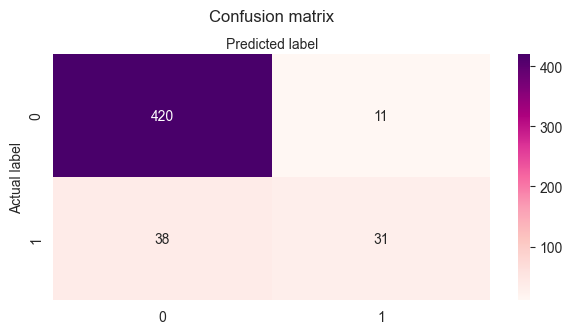

Accuracy: 0.902
Precision: 0.7380952380952381
Recall: 0.4492753623188406
F1 Score: 0.5585585585585586
Mathews Correlation Coefficient: 0.5268887316893606


In [30]:
preds = best_model.predict(x_test_scaled)
model_statistics_classification(y_test, preds);

MLP Classifier

In [27]:
param_grid = param_grid = {
    'hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 50, 25)],
    'alpha': [0.0001, 0.001, 0.01],
    'learning_rate': ['constant', 'invscaling', 'adaptive'],
}
MLPC= MLPClassifier(random_state= 1)
# Perform grid search with cross-validation
grid_search = GridSearchCV(estimator=MLPC, param_grid=param_grid, cv=4, verbose= 1, scoring= 'f1')
grid_search.fit(x_train_scaled, y_train)
# Get the best model and its hyperparameters
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_
print(best_params)

Fitting 5 folds for each of 36 candidates, totalling 180 fits



KeyboardInterrupt



In [40]:
MLPC= MLPClassifier(random_state= 1,activation= 'tanh', alpha= 0.01, hidden_layer_sizes= (100, 100, 100), learning_rate= 'invscaling', max_iter=200)
MLPC.fit(x_train_scaled, y_train)

MLPClassifier(activation='tanh', alpha=0.01, hidden_layer_sizes=(100, 100, 100),
              learning_rate='invscaling', random_state=1)

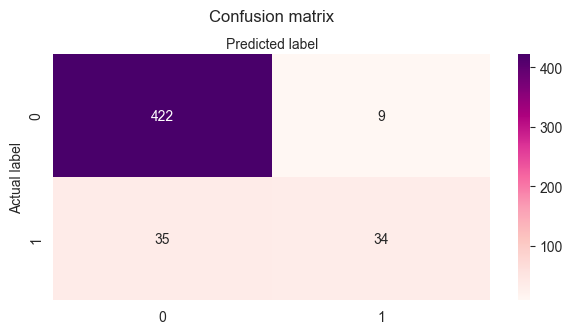

Accuracy: 0.912
Precision: 0.7906976744186046
Recall: 0.4927536231884058
F1 Score: 0.6071428571428571
Mathews Correlation Coefficient: 0.5804903666539535


In [39]:
preds = MLPC.predict(x_test_scaled)
model_statistics_classification(y_test, preds);

Boost Class

In [34]:
class customMLPClassifier(MLPClassifier):
    def resample_with_replacement(self, X_train, y_train, sample_weight):

        # normalize sample_weights if not already
        sample_weight = sample_weight / sample_weight.sum(dtype=np.float64)

        X_train_resampled = np.zeros((len(X_train), len(X_train[0])), dtype=np.float32)
        y_train_resampled = np.zeros((len(y_train)), dtype=np.int)
        for i in range(len(X_train)):
            # draw a number from 0 to len(X_train)-1
            draw = np.random.choice(np.arange(len(X_train)), p=sample_weight)

            # place the X and y at the drawn number into the resampled X and y
            X_train_resampled[i] = X_train[draw]
            y_train_resampled[i] = y_train[draw]

        return X_train_resampled, y_train_resampled


    def fit(self, X, y, sample_weight=None):
        if sample_weight is not None:
            X, y = self.resample_with_replacement(X, y, sample_weight)

        return self._fit(X, y, incremental=(self.warm_start and
                                            hasattr(self, "classes_")))

In [40]:
ADC = AdaBoostClassifier(customMLPClassifier(random_state= 1,activation= 'tanh', alpha= 0.0001, hidden_layer_sizes= (100, 100, 100), learning_rate= 'invscaling'), n_estimators=50, algorithm='SAMME', random_state=1)
ADC.fit(x_train_scaled, y_train)

AdaBoostClassifier(algorithm='SAMME',
                   estimator=customMLPClassifier(activation='tanh',
                                                 hidden_layer_sizes=(100, 100,
                                                                     100),
                                                 learning_rate='invscaling',
                                                 random_state=1),
                   random_state=1)

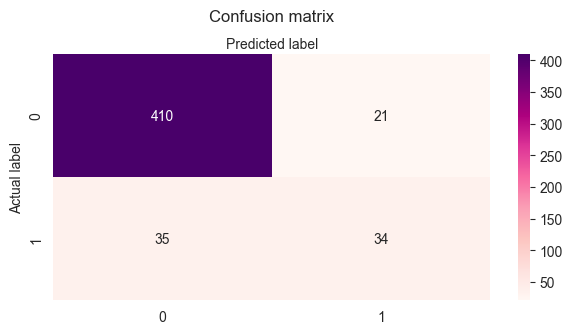

Accuracy: 0.888
Precision: 0.6181818181818182
Recall: 0.4927536231884058
F1 Score: 0.5483870967741936
Mathews Correlation Coefficient: 0.4894562458898007


In [41]:
preds = ADC.predict(x_test_scaled)
model_statistics_classification(y_test, preds);

Random Forest

In [35]:
param_grid = {
    'n_estimators': [100, 200, 300],  # Number of trees in the forest
    'criterion': ['gini', 'entropy'],  # Splitting criterion
    'max_depth': [5, 10, 15],  # Maximum depth of the tree
    'min_samples_split': [2, 5, 10],  # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 4],  # Minimum number of samples required to be at a leaf node
}
RFC= RandomForestClassifier(random_state= 1)
# Perform grid search with cross-validation
grid_search = GridSearchCV(estimator=RFC, param_grid=param_grid, cv=4, verbose= 1, scoring= 'f1')
grid_search.fit(x_train_scaled, y_train)
# Get the best model and its hyperparameters
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_
print(best_params)

Fitting 4 folds for each of 162 candidates, totalling 648 fits
{'criterion': 'entropy', 'max_depth': 15, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}


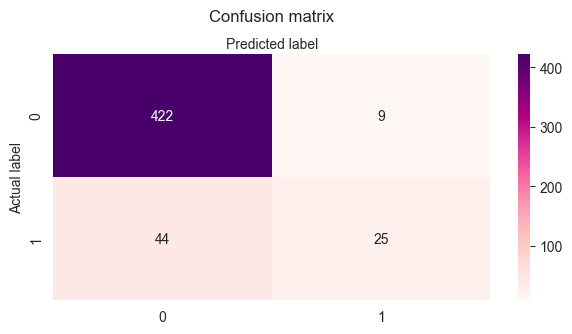

Accuracy: 0.894
Precision: 0.7352941176470589
Recall: 0.36231884057971014
F1 Score: 0.48543689320388345
Mathews Correlation Coefficient: 0.46777990543609405


In [36]:
preds = best_model.predict(x_test_scaled)
model_statistics_classification(y_test, preds);

SVM

In [40]:
param_grid = {
    'C': [0.1, 1, 10],  # Regularization parameter
    'kernel': ['linear', 'rbf', 'poly'],  # Kernel type
    'gamma': ['scale', 'auto'],  # Kernel coefficient
    'degree': [2, 3, 4],  # Degree of the polynomial kernel function
    'shrinking': [True, False],  # Whether to use the shrinking heuristic
    'class_weight': ['balanced'],  # Weights associated with classes
}
SVM= SVC(random_state= 1)
# Perform grid search with cross-validation
grid_search = GridSearchCV(estimator=SVM, param_grid=param_grid, cv=4, verbose= 1, scoring= 'f1')
grid_search.fit(x_train_scaled, y_train)
# Get the best model and its hyperparameters
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_
print(best_params)

Fitting 4 folds for each of 108 candidates, totalling 432 fits
{'C': 10, 'class_weight': 'balanced', 'degree': 2, 'gamma': 'scale', 'kernel': 'rbf', 'shrinking': True}


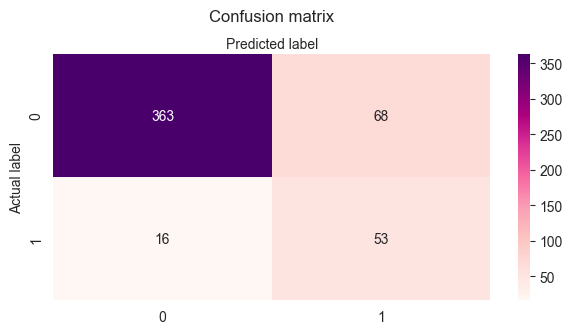

Accuracy: 0.832
Precision: 0.4380165289256198
Recall: 0.7681159420289855
F1 Score: 0.5578947368421052
Mathews Correlation Coefficient: 0.4915017700415505


In [41]:
preds = best_model.predict(x_test_scaled)
model_statistics_classification(y_test, preds);

Prepping for kaggle

In [26]:
def kaggle_prep(model, predict_df, version_num:str, og_df):
    '''

    :param model: modelo a utilizar nas previsões
    :param predict_df: a dataframe a utilizar nas previsoes ja tratada
    :param version_num: numero da tentativa do kaggle
    :param og_df: df com o index original
    :return: o csv pronto a submeter no kaggle
    '''
    preds_kaggle = pd.Series(model.predict(predict_df))
    preds_kaggle_df = pd.DataFrame(pd.concat([og_df['CustomerID'], preds_kaggle], axis=1))

    preds_kaggle_df= preds_kaggle_df.rename(columns={0: 'DepVar'})
    preds_kaggle_df.set_index('CustomerID', inplace=True)

    preds_kaggle_df = preds_kaggle_df.astype({'DepVar': int})
    preds_kaggle_df.to_csv(f'Group09_Version{version_num}.csv')

    return preds_kaggle_df

In [27]:
def data_cleaning_kaggle(df):

    '''

    :param df: dataframe inicial
    :return: dataframe com o mesmo tratamento que o projeto 1
    '''
    final_df = df
    final_df["Gender"] = final_df['Name'].str.partition(" ")[0]
    final_df = final_df.replace({"Gender":{"Mr.": 1,"Miss": 0,"Mrs.": 0}}) #Name Var Processing
    final_df.drop('Name', axis= 1, inplace= True)

    final_df['Education'] = final_df['Education'].str.title()
    edu_encode = pd.get_dummies(final_df.Education, drop_first= True)
    final_df = pd.concat([final_df, edu_encode], axis = 1) #Marital Status Var Processing
    final_df.drop('Education', axis= 1, inplace = True)

    final_df['Marital_Status'] = final_df['Marital_Status'].str.title()
    marital_encode = pd.get_dummies(final_df.Marital_Status, drop_first= True)
    final_df = pd.concat([final_df, marital_encode], axis = 1) #Marital Status Var Processing
    final_df.drop('Marital_Status', axis= 1, inplace = True)

    final_df['Age'] = final_df.Birthyear.apply(lambda x: date.today().year-x)
    final_df.drop('Birthyear', axis=1, inplace=True) #Age Var Processing

    final_df = final_df.replace({"Date_Adherence":{"2/29/2022": datetime.strptime("2022-03-01", '%Y-%m-%d')}})

    final_df["MntTotal"] = final_df['MntMeat&Fish'] + final_df['MntEntries'] + final_df['MntVegan&Vegetarian'] + final_df['MntDrinks'] + final_df['MntDesserts'] + final_df['MntAdditionalRequests']

    final_df.drop(['MntMeat&Fish', 'MntEntries', 'MntVegan&Vegetarian', 'MntDrinks', 'MntDesserts', 'MntAdditionalRequests'], axis=1, inplace=True)

    final_df['Days_As_Client'] = final_df['Date_Adherence'].apply(lambda x: (date.today() - x.date()).days) #Date Adherence Var Processing
    final_df['Days_As_Client'] = final_df['Days_As_Client'].apply(lambda x: 1 if x < 1 else x)
    final_df.drop('Date_Adherence', axis= 1, inplace = True)

    final_df['Response_Campaigns'] = final_df['Response_Cmp1'] + final_df['Response_Cmp2'] + final_df['Response_Cmp3'] + final_df['Response_Cmp4'] + final_df[
       'Response_Cmp5']
    final_df.drop(['Response_Cmp1', 'Response_Cmp2', 'Response_Cmp3', 'Response_Cmp4', 'Response_Cmp5'], axis=1, inplace=True)

    final_df.drop(['CostContact', 'Revenue'], axis=1, inplace=True)

    return final_df

In [28]:
predict_clean = data_cleaning_kaggle(predict)
predict_fill= fill_data(predict_clean)
predict_filt = predict_fill[selected_features]
predict_scale = scaler.transform(predict_filt)
preds = MLPC.predict(predict_scale)
kaggle_prep(model= MLPC, predict_df= predict_scale, version_num= '44', og_df= predict)

,DepVar
CustomerID,
3102,0
3105,0
3108,0
3111,0
3120,0
...,...
18186,0
18189,0
18192,0


In [29]:
predict_clean

,CustomerID,Income,Kid_Younger6,Children_6to18,Recency,NumOfferPurchases,NumAppPurchases,NumTakeAwayPurchases,NumStorePurchases,NumAppVisitsMonth,...,Master,Phd,Married,Single,Together,Widow,Age,MntTotal,Days_As_Client,Response_Campaigns
0,3102,99861,0,0,66.0,1,8,6,10,4,...,0,0,0,0,1,0,60,19488.0,588,1
1,3105,102929,0,1,10.0,3,9,4,13,5,...,0,1,0,0,0,0,60,11673.0,692,0
2,3108,24625,1,1,65.0,5,5,2,3,9,...,0,1,0,0,1,0,52,706.0,591,1
3,3111,120449,0,0,75.0,1,7,6,11,1,...,1,0,1,0,0,0,70,20356.0,591,1
4,3120,26231,1,0,53.0,1,2,1,3,7,...,0,0,1,0,0,0,33,296.0,908,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2495,18186,58821,0,1,20.0,3,6,2,5,7,...,0,0,1,0,0,0,47,3406.0,870,0
2496,18189,64175,0,1,52.0,2,9,6,3,7,...,0,0,0,0,1,0,50,5634.0,1011,1
2497,18192,81783,0,1,97.0,2,6,2,3,6,...,0,0,0,0,1,0,57,1652.0,416,1
2498,18195,59722,0,0,72.0,2,9,4,5,6,...,0,0,0,0,1,0,48,14268.0,766,1
